## Importing the required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models

## Defining our dataset

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 
CHANNELS = 3

In [3]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
n_classes = len(class_names)
n_classes

3

In [6]:
len(ds) 

68

## Examples of the images

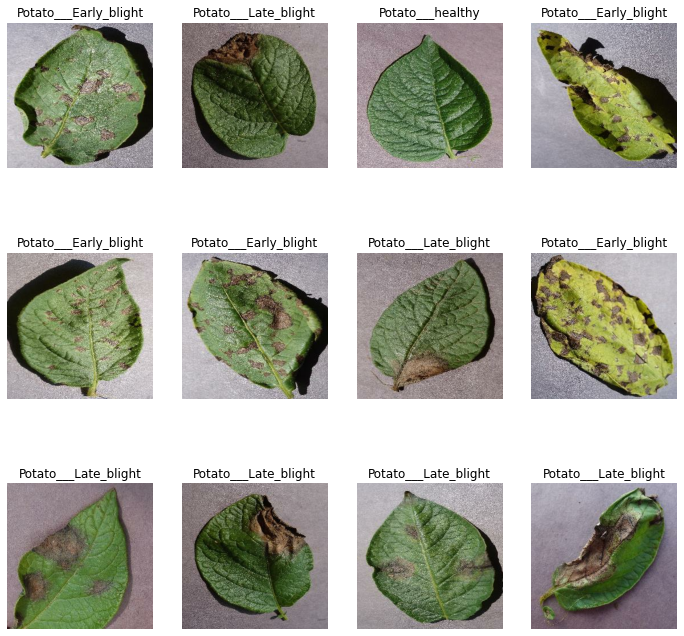

In [7]:
plt.figure(figsize = (12,12))
for image_batch,label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        image = image_batch[i].numpy().astype("uint8")
        plt.imshow(image)#.imshow takes 3D image
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        


## Split of the dataset into training, testing and validation sets

* 80% > training
* 10% > Validation
* 10% > Test

In [8]:
def train_test_val_split(ds,train_split = 0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 42)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [9]:
train_ds,val_ds,test_ds = train_test_val_split(ds)

In [10]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

## Optimizing the data to run efficiently 

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Data Augmentation 


In [12]:
dataAug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),# incase the image is not the correct size
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255), # preprocessing it to (0-1)
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

## Defining the model

In [13]:
model = models.Sequential([
    dataAug,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    #Flattening to an array of neurons
    layers.Flatten(),
    
    layers.Dense(64,activation = 'relu'),
    
    layers.Dense(n_classes,activation = 'softmax')
])
# The model has 6 convolution layers 

## Building the model

In [14]:
model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

## Compiling the model

In [15]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

## Training the model

In [16]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size =  BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds,# validation data is optional
    
)

Epoch 1/50
54/54 [==============================] - 12s 104ms/step - loss: 0.9233 - accuracy: 0.4865 - val_loss: 0.8206 - val_accuracy: 0.4323
Epoch 2/50
54/54 [==============================] - 4s 75ms/step - loss: 0.7031 - accuracy: 0.6802 - val_loss: 0.4789 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 4s 76ms/step - loss: 0.5462 - accuracy: 0.7817 - val_loss: 0.6523 - val_accuracy: 0.7031
Epoch 4/50
54/54 [==============================] - 4s 76ms/step - loss: 0.4262 - accuracy: 0.8228 - val_loss: 0.3203 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 4s 76ms/step - loss: 0.3420 - accuracy: 0.8750 - val_loss: 0.2724 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 4s 76ms/step - loss: 0.3369 - accuracy: 0.8592 - val_loss: 0.2607 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 4s 76ms/step - loss: 0.2361 - accuracy: 0.9149 - val_loss: 0.4378 - val_accuracy: 0.8490
Epoch 8/50


## Testing the model

In [17]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 22ms/step - loss: 0.0258 - accuracy: 0.9844


In [18]:
print("The Score of the model on a test dataset is : ",round(scores[1]*100,2),"%")

The Score of the model on a test dataset is :  98.44 %


In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

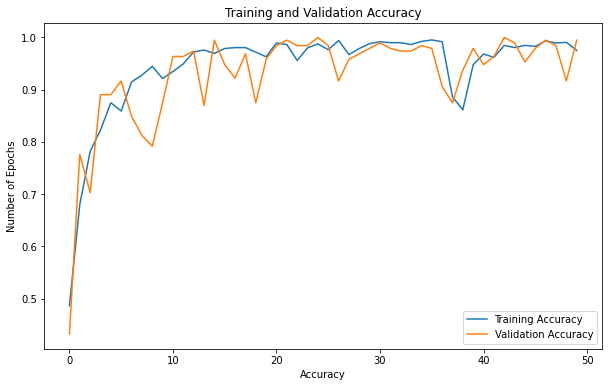

In [20]:
plt.figure(figsize = (10,6))
plt.plot(history.history["accuracy"],label = "Training Accuracy")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Number of Epochs")
plt.legend(loc = "lower right");

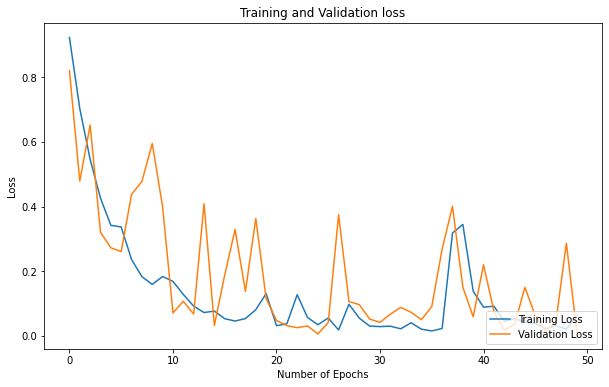

In [21]:
plt.figure(figsize = (10,6))
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Training and Validation loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend(loc = "lower right");

In [22]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    return predicted_class

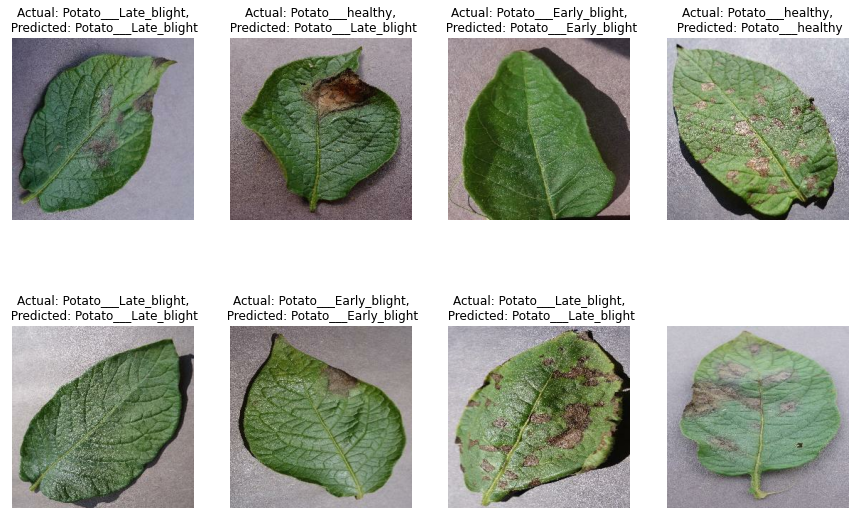

In [23]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    
    for i in range(8):
    
   
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        
        predicted_class = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image)
        plt.axis("off")